In [1]:
import pandas as pd
import glob
import numpy as np

## Load Datasets

In [2]:
rotten_tomatoes_raw = pd.read_csv('rotten_tomatoes/movie_info.csv')

In [3]:
imdb_dict = dict()
num_rows = 0
for path in glob.glob(f'imdb/*.csv'):
    df = pd.read_csv(path)
    imdb_dict[path] = df
    num_rows += df.shape[0]

In [4]:
imdb_raw = pd.concat(imdb_dict.values(), ignore_index=True)

In [5]:
oscar_raw = pd.read_csv('oscar_award/full_data.csv', sep='\t')

## Data Cleaning

### Rotten Tomatoes Ratings

In [6]:
rotten_tomatoes = rotten_tomatoes_raw.dropna()
rotten_tomatoes['critic_score'] = rotten_tomatoes['critic_score'].apply(lambda x: float(x[:-1])/100)
rotten_tomatoes['audience_score'] = rotten_tomatoes['audience_score'].apply(lambda x: float(x[:-1])/100)
def clean_date(date):
    year = date[-4:]
    try:
        return int(year)
    except:
        return None
rotten_tomatoes['release_year'] = rotten_tomatoes['release_date'].apply(clean_date)
rotten_tomatoes = rotten_tomatoes.dropna()
rotten_tomatoes['release_year'] = rotten_tomatoes['release_year'].astype(int)
rotten_tomatoes = rotten_tomatoes.drop(columns='url')

/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/ipykernel_97146/2090178666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes['critic_score'] = rotten_tomatoes['critic_score'].apply(lambda x: float(x[:-1])/100)
/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/ipykernel_97146/2090178666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rotten_tomatoes['audience_score'] = rotten_tomatoes['audience_score'].apply(lambda x: float(x[:-1])/100)
/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/i

In [7]:
imdb = imdb_raw.drop_duplicates()
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')
imdb.loc[~imdb['year'].between(1880, 2025), 'year'] = np.nan
imdb = imdb.dropna(subset=['year'])
imdb['year'] = imdb['year'].astype(int)
imdb['votes'] = imdb.groupby('movie_id')['votes'].transform(lambda ser: ser.mean())
imdb = imdb.drop_duplicates()

/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/ipykernel_97146/2601930290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')


In [8]:
imdb_tomatoes = rotten_tomatoes.merge(imdb, left_on=['title', 'release_year'], right_on=['movie_name', 'year'])

In [9]:
oscar = oscar_raw.iloc[:, :12]

In [10]:
imdb_tomatoes_oscar = imdb_tomatoes.merge(oscar, left_on='movie_id', right_on='FilmId')

In [11]:
rotten_tomatoes.to_csv('data/rotten_tomatoes.csv', index=False)
imdb_tomatoes.to_csv('data/imdb_tomatoes.csv', index=False)
imdb_tomatoes_oscar.to_csv('data/imdb_tomatoes_oscar', index=False)

## EDA

       critic_score  audience_score
count   9239.000000     9239.000000
mean       0.574691        0.618560
std        0.276039        0.201007
min        0.000000        0.030000
25%        0.350000        0.460000
50%        0.610000        0.630000
75%        0.820000        0.790000
max        1.000000        1.000000


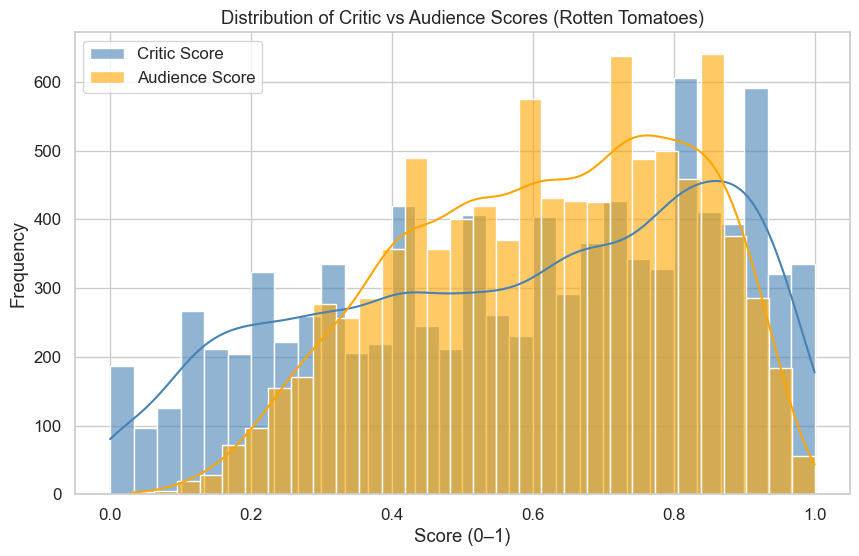

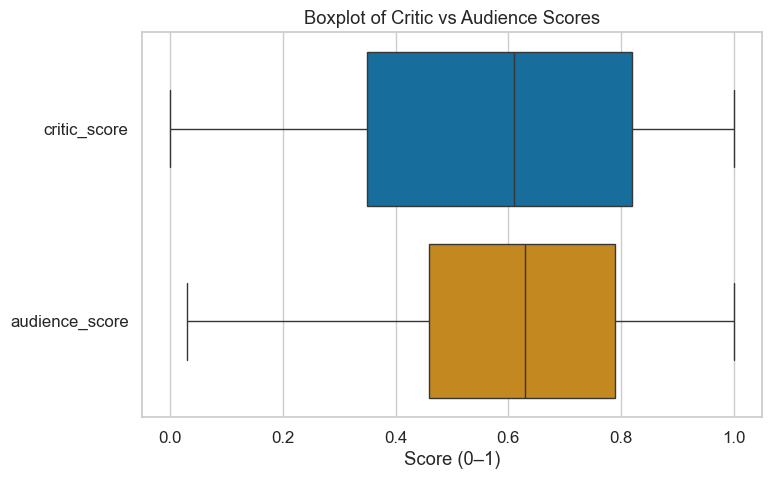

<Figure size 700x600 with 0 Axes>

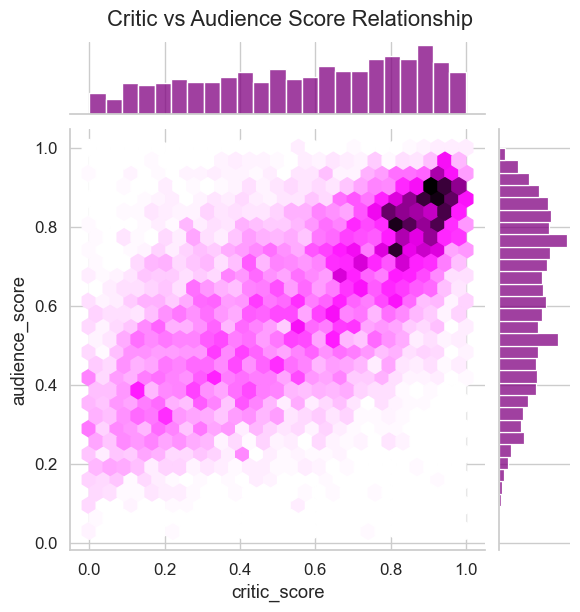

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# set general plot aesthetics
sns.set(style="whitegrid", palette="colorblind", font_scale=1.1)

# inspect basic summary
print(rotten_tomatoes[['critic_score', 'audience_score']].describe())

# 1. histogram + KDE (kernel density estimate)
plt.figure(figsize=(10, 6))
sns.histplot(rotten_tomatoes['critic_score'], bins=30, kde=True, color='steelblue', label='Critic Score', alpha=0.6)
sns.histplot(rotten_tomatoes['audience_score'], bins=30, kde=True, color='orange', label='Audience Score', alpha=0.6)
plt.title('Distribution of Critic vs Audience Scores (Rotten Tomatoes)')
plt.xlabel('Score (0–1)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 2. side-by-side boxplots
plt.figure(figsize=(8, 5))
sns.boxplot(data=rotten_tomatoes[['critic_score', 'audience_score']], orient='h')
plt.title('Boxplot of Critic vs Audience Scores')
plt.xlabel('Score (0–1)')
plt.show()

# 3. optional: joint distribution (relationship between critic and audience scores)
plt.figure(figsize=(7, 6))
sns.jointplot(
    data=rotten_tomatoes, 
    x='critic_score', 
    y='audience_score', 
    kind='hex', 
    color='purple'
)
plt.suptitle('Critic vs Audience Score Relationship', y=1.02)
plt.show()


Winner                       False         True 
critic_score   count  2.978000e+03  1.031000e+03
               mean   8.148925e-01  8.684966e-01
               std    1.639978e-01  1.161334e-01
               min    8.000000e-02  1.700000e-01
               25%    7.600000e-01  8.400000e-01
               50%    8.600000e-01  9.100000e-01
               75%    9.300000e-01  9.400000e-01
               max    1.000000e+00  1.000000e+00
audience_score count  2.978000e+03  1.031000e+03
               mean   8.004231e-01  8.463240e-01
               std    1.303068e-01  1.086026e-01
               min    1.900000e-01  2.000000e-01
               25%    7.400000e-01  8.100000e-01
               50%    8.300000e-01  8.700000e-01
               75%    8.900000e-01  9.200000e-01
               max    9.900000e-01  9.900000e-01
rating         count  2.935000e+03  1.025000e+03
               mean   7.466440e+00  7.869951e+00
               std    7.143013e-01  6.589635e-01
               min  

/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/ipykernel_97146/3917293963.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  imdb_tomatoes_oscar['Winner'] = imdb_tomatoes_oscar['Winner'].fillna(False).astype(bool)


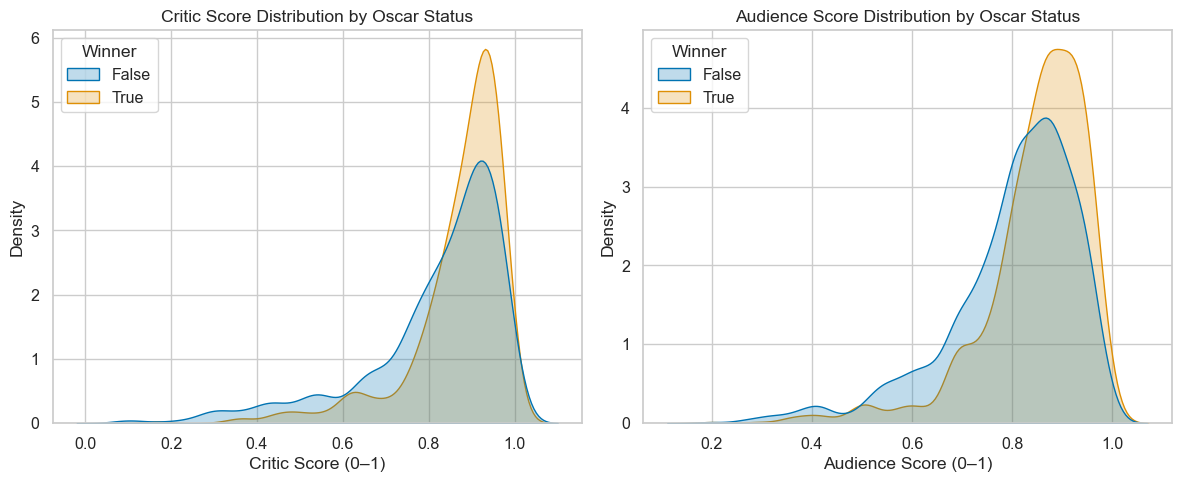

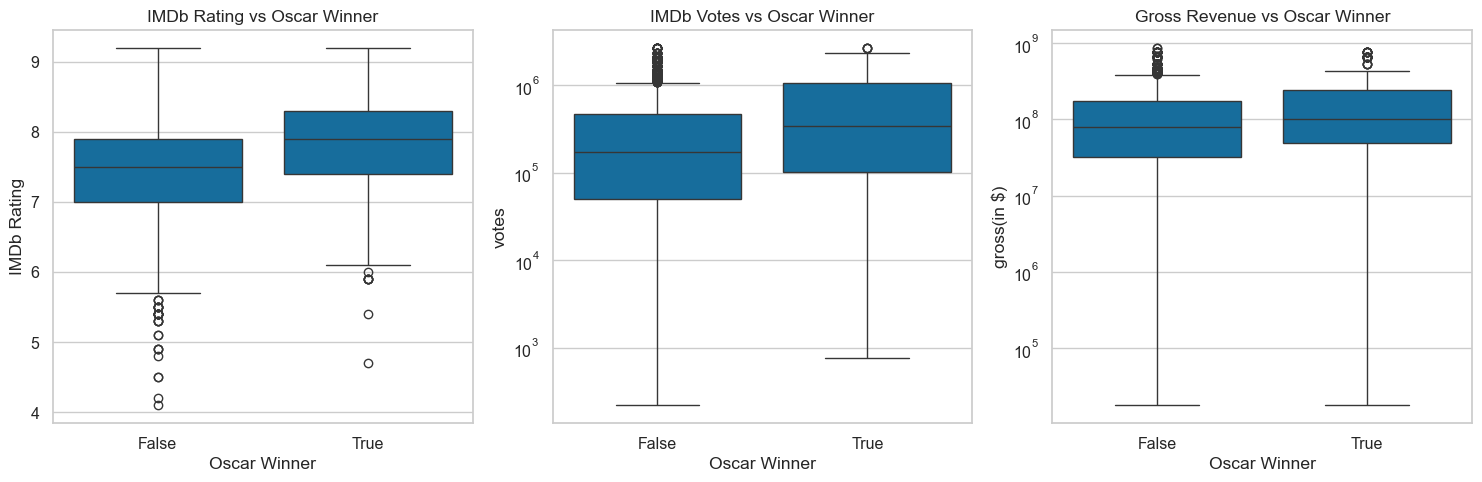

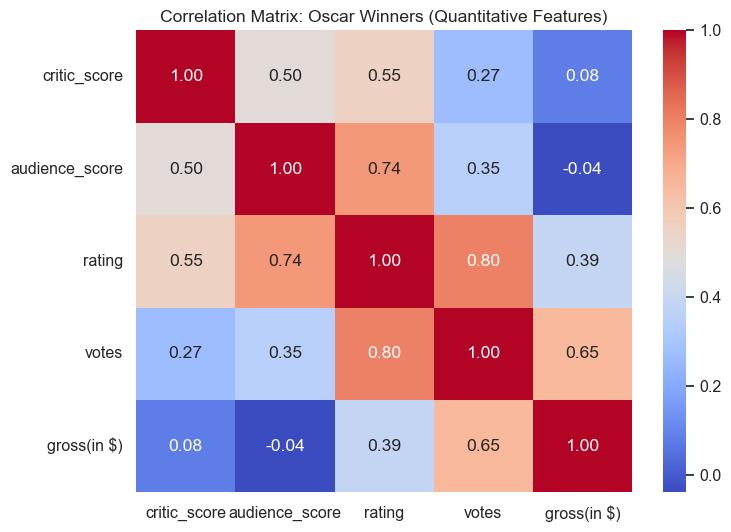

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# ensure Winner is boolean
imdb_tomatoes_oscar['Winner'] = imdb_tomatoes_oscar['Winner'].fillna(False).astype(bool)

# define key quantitative features to compare
quant_cols = ['critic_score', 'audience_score', 'rating', 'votes', 'gross(in $)']

# summary stats by Winner
summary = imdb_tomatoes_oscar.groupby('Winner')[quant_cols].describe().T
print(summary)

# set up seaborn style
sns.set(style="whitegrid", palette="colorblind", font_scale=1.05)

# 1. KDE distributions for critic and audience scores
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(
    data=imdb_tomatoes_oscar, x='critic_score', hue='Winner',
    fill=True, common_norm=False, ax=axes[0]
)
axes[0].set_title("Critic Score Distribution by Oscar Status")
axes[0].set_xlabel("Critic Score (0–1)")

sns.kdeplot(
    data=imdb_tomatoes_oscar, x='audience_score', hue='Winner',
    fill=True, common_norm=False, ax=axes[1]
)
axes[1].set_title("Audience Score Distribution by Oscar Status")
axes[1].set_xlabel("Audience Score (0–1)")
plt.tight_layout()
plt.show()

# 2. Boxplots for IMDb rating, votes, and gross revenue
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=imdb_tomatoes_oscar, x='Winner', y='rating', ax=axes[0])
axes[0].set_title("IMDb Rating vs Oscar Winner")
axes[0].set_xlabel("Oscar Winner")
axes[0].set_ylabel("IMDb Rating")

sns.boxplot(data=imdb_tomatoes_oscar, x='Winner', y='votes', ax=axes[1])
axes[1].set_yscale('log')  # skewed distribution
axes[1].set_title("IMDb Votes vs Oscar Winner")
axes[1].set_xlabel("Oscar Winner")

sns.boxplot(data=imdb_tomatoes_oscar, x='Winner', y='gross(in $)', ax=axes[2])
axes[2].set_yscale('log')
axes[2].set_title("Gross Revenue vs Oscar Winner")
axes[2].set_xlabel("Oscar Winner")
plt.tight_layout()
plt.show()

# 3. Optional: correlation heatmap for numeric features among Oscar winners only
winners_corr = imdb_tomatoes_oscar[imdb_tomatoes_oscar['Winner'] == True][quant_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(winners_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Oscar Winners (Quantitative Features)")
plt.show()


Critic score outliers: 0 rows
Audience score outliers: 0 rows


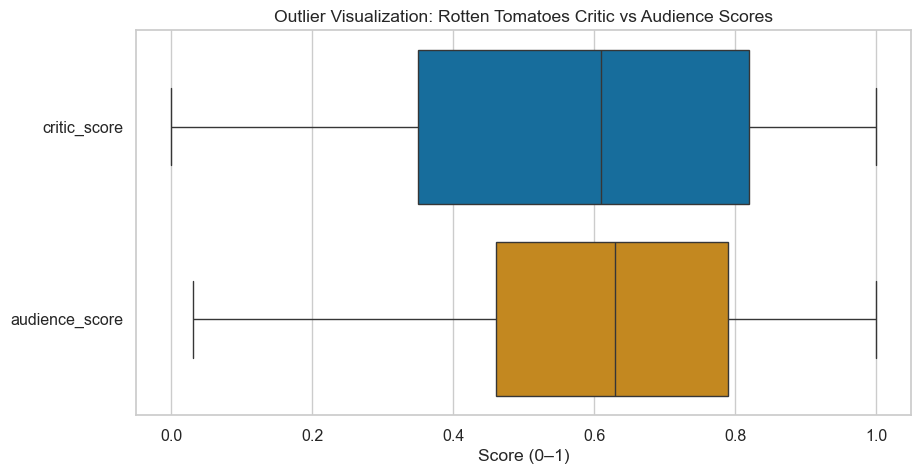

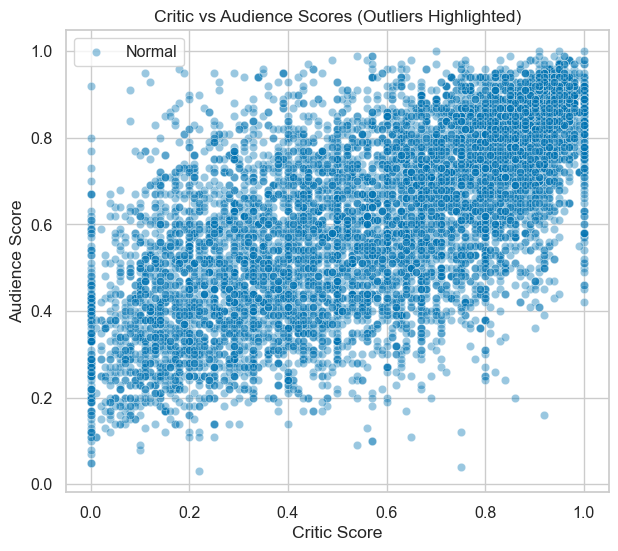

Oscar merged data - Critic score outliers: 313 rows
Oscar merged data - Audience score outliers: 189 rows


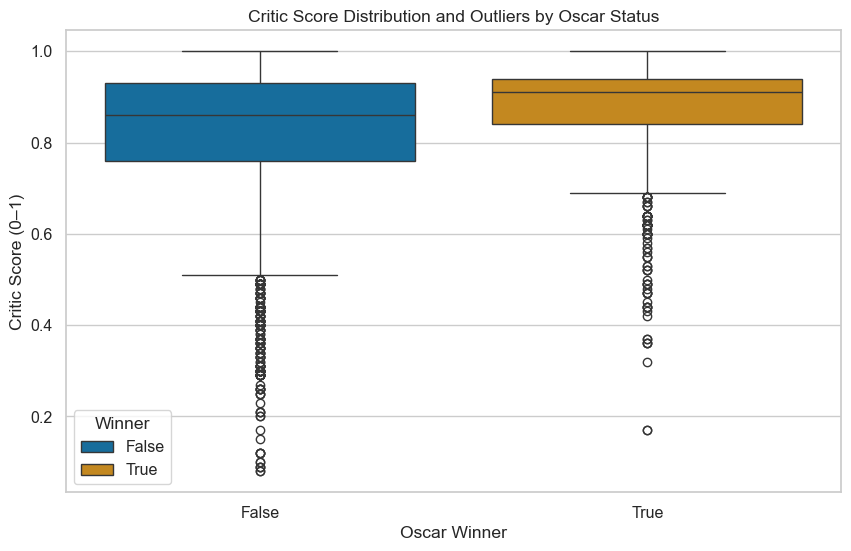

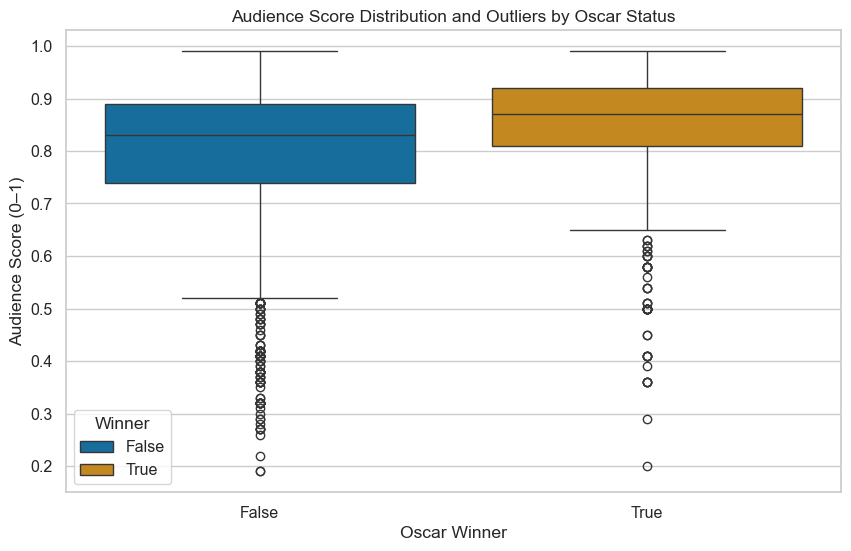

Top 5 lowest critic scores:


,title,critic_score,audience_score
265,The Villain,0.0,0.39
476,The Thing With Two Heads,0.0,0.25
477,The Thing With Two Heads,0.0,0.25
481,Night of the Lepus,0.0,0.27
715,Homecoming,0.0,0.33


Top 5 highest critic scores:


,title,critic_score,audience_score
6,Woodstock,1.0,0.92
16,Days and Nights in the Forest,1.0,0.97
29,The Butcher,1.0,0.84
42,Woodstock,1.0,0.92
90,On a Clear Day You Can See Forever,1.0,0.75


In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Helper function for IQR-based outlier detection ---
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers, lower, upper


# ========================================================
# 1️⃣ Rotten Tomatoes Dataset Outliers
# ========================================================
outliers_critic, lower_c, upper_c = detect_outliers(rotten_tomatoes, 'critic_score')
outliers_audience, lower_a, upper_a = detect_outliers(rotten_tomatoes, 'audience_score')

print(f"Critic score outliers: {len(outliers_critic)} rows")
print(f"Audience score outliers: {len(outliers_audience)} rows")

# --- Boxplot visualization ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=rotten_tomatoes[['critic_score', 'audience_score']], orient='h')
plt.title('Outlier Visualization: Rotten Tomatoes Critic vs Audience Scores')
plt.xlabel('Score (0–1)')
plt.show()

# --- Scatter plot highlighting outliers ---
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=rotten_tomatoes, x='critic_score', y='audience_score', alpha=0.4, label='Normal'
)
sns.scatterplot(
    data=outliers_critic, x='critic_score', y='audience_score', color='red', label='Critic Outlier'
)
sns.scatterplot(
    data=outliers_audience, x='critic_score', y='audience_score', color='orange', label='Audience Outlier'
)
plt.title('Critic vs Audience Scores (Outliers Highlighted)')
plt.xlabel('Critic Score')
plt.ylabel('Audience Score')
plt.legend()
plt.show()


# ========================================================
# 2️⃣ IMDb + Rotten Tomatoes + Oscar Dataset Outliers
# ========================================================
outliers_critic_oscar, lower_c2, upper_c2 = detect_outliers(imdb_tomatoes_oscar, 'critic_score')
outliers_audience_oscar, lower_a2, upper_a2 = detect_outliers(imdb_tomatoes_oscar, 'audience_score')

print(f"Oscar merged data - Critic score outliers: {len(outliers_critic_oscar)} rows")
print(f"Oscar merged data - Audience score outliers: {len(outliers_audience_oscar)} rows")

# --- Boxplot visualization by Oscar status ---
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=imdb_tomatoes_oscar, 
    x='Winner', 
    y='critic_score', 
    hue='Winner',
    palette='colorblind'
)
plt.title('Critic Score Distribution and Outliers by Oscar Status')
plt.xlabel('Oscar Winner')
plt.ylabel('Critic Score (0–1)')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=imdb_tomatoes_oscar, 
    x='Winner', 
    y='audience_score', 
    hue='Winner',
    palette='colorblind'
)
plt.title('Audience Score Distribution and Outliers by Oscar Status')
plt.xlabel('Oscar Winner')
plt.ylabel('Audience Score (0–1)')
plt.show()


# ========================================================
# 3️⃣ Optional: List Top Extreme Outliers for Inspection
# ========================================================
print("Top 5 lowest critic scores:")
display(rotten_tomatoes.nsmallest(5, 'critic_score')[['title', 'critic_score', 'audience_score']])

print("Top 5 highest critic scores:")
display(rotten_tomatoes.nlargest(5, 'critic_score')[['title', 'critic_score', 'audience_score']])


In [15]:
unique_genres = set()
for lst in imdb_tomatoes['genre'].apply(lambda x: x.split(', ')):
    for genre in lst:
        unique_genres.add(genre)

In [16]:
unique_genres

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

In [17]:
# df = your original dataframe (e.g., imdb_tomatoes)
# 'genre' looks like: "Action, Drama, Thriller"

# split the comma-separated string into a list, then explode
movies_exploded = (
    imdb_tomatoes.assign(genre=imdb_tomatoes['genre'].str.split(r',\s*'))  # split on comma + optional spaces
      .explode('genre', ignore_index=True)           # one row per movie+genre
)

# tidy: strip spaces and drop blanks/NaNs
movies_exploded['genre'] = movies_exploded['genre'].str.strip()
movies_exploded = movies_exploded[movies_exploded['genre'].notna() & (movies_exploded['genre'] != '')]


In [18]:
movies_exploded.groupby('genre').apply(lambda df: (df['critic_score'] - df['audience_score']).abs().mean()).sort_values(ascending=False)

/var/folders/02/pnxb037d1s55wxx4bpzhn2s00000gn/T/ipykernel_97146/851805311.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  movies_exploded.groupby('genre').apply(lambda df: (df['critic_score'] - df['audience_score']).abs().mean()).sort_values(ascending=False)


genre
Adult        0.220000
Sport        0.198788
Music        0.189588
Romance      0.180809
Musical      0.174231
Family       0.172936
Comedy       0.171438
Fantasy      0.168234
Western      0.168000
Horror       0.164744
Drama        0.164423
Action       0.162348
Crime        0.162244
Thriller     0.158006
Mystery      0.154836
Adventure    0.152962
History      0.148024
Film-Noir    0.146154
Biography    0.143016
Animation    0.140562
Sci-Fi       0.132717
War          0.129524
dtype: float64

<Axes: xlabel='release_year'>

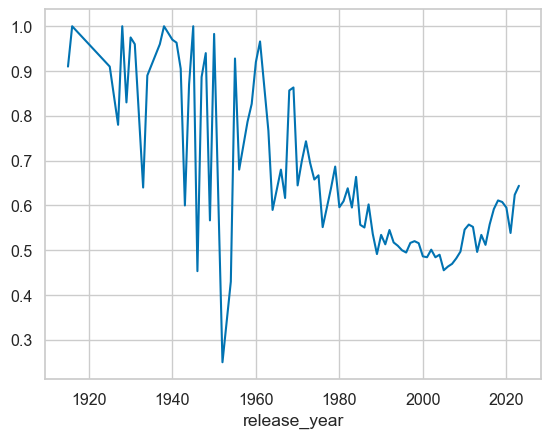

In [19]:
imdb_tomatoes.groupby('release_year')['critic_score'].mean().plot(kind='line')

<Axes: xlabel='release_year'>

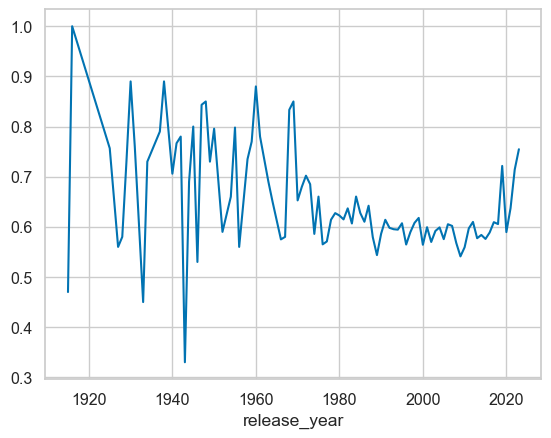

In [20]:
imdb_tomatoes.groupby('release_year')['audience_score'].mean().plot(kind='line')

In [21]:
critic_top_30 = set(imdb_tomatoes.sort_values('critic_score').head(30)['title'])

In [22]:
audience_top_30 = set(imdb_tomatoes.sort_values('audience_score').head(30)['title'])

In [23]:
critic_top_30

{'10 Minutes Gone',
 'Adrenalin: Fear the Rush',
 'American Ninja',
 'Ballistic: Ecks vs. Sever',
 'Caught Up',
 'Gable and Lombard',
 'Hard Kill',
 'Hero and the Terror',
 'Homecoming',
 'Hot to Trot',
 'Johnny Be Good',
 'Kinjite: Forbidden Subjects',
 'Maxie',
 "National Lampoon's Senior Trip",
 'Night of the Lepus',
 'Out of Death',
 'Police Academy 6: City Under Siege',
 'Problem Child',
 'Rainbow Brite and the Star Stealer',
 'State Property',
 'Staying Alive',
 'The Big Green',
 'The Blue Iguana',
 'The Disappointments Room',
 'The Horror Show',
 "The Slugger's Wife",
 'Two Moon Junction',
 'Warlock: The Armageddon',
 'Windows'}

In [24]:
imdb_tomatoes.sort_values('audience_score').head(30)['title']

936                             Death Valley
4554                          Fall Down Dead
3579                                  Cuckoo
6195                Jeepers Creepers: Reborn
6069                          Zeros and Ones
6147                            Zero Contact
768                                  Windows
2027                                    Ruby
590                                     Ruby
997                        Alone in the Dark
5122                     Leprechaun: Origins
5684             Escape Plan: The Extractors
3821                       Alone in the Dark
537                                Tentacles
6309                       Peter Pan & Wendy
1653                       Physical Evidence
745                        Avalanche Express
25      Tell Me That You Love Me, Junie Moon
6061                   Home Sweet Home Alone
5475                    Just Getting Started
5537                            Future World
5114                             Mercenaries
564       

In [25]:
critic_90 = np.percentile(imdb_tomatoes['critic_score'], 98)

In [26]:
audience_90 = np.percentile(imdb_tomatoes['audience_score'], 98)

In [27]:
imdb_tomatoes[(imdb_tomatoes['critic_score'] >= critic_90) & (imdb_tomatoes['audience_score'] >= audience_90)]

,title,release_date,critic_score,audience_score,release_year,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
145,The Godfather,"Released Mar 15, 1972",0.97,0.98,1972,tt0068646,The Godfather,1972,R,175 min,"Crime, Drama",9.2,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,/name/nm0000338/,"Marlon Brando, \nAl Pacino, \nJames Caan, \nDi...","/name/nm0000008/,/name/nm0000199/,/name/nm0001...",1875646.0,134966411.0
146,The Godfather,"Released Mar 15, 1972",0.97,0.98,1972,tt0068646,The Godfather,1972,R,175 min,"Crime, Drama",9.2,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,/name/nm0000338/,"Marlon Brando, \nAl Pacino, \nJames Caan, \nDi...","/name/nm0000008/,/name/nm0000199/,/name/nm0001...",1875646.0,134966411.0
161,The Godfather,"Released Mar 15, 1972",0.97,0.98,1972,tt0068646,The Godfather,1972,R,175 min,"Crime, Drama",9.2,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,/name/nm0000338/,"Marlon Brando, \nAl Pacino, \nJames Caan, \nDi...","/name/nm0000008/,/name/nm0000199/,/name/nm0001...",1875646.0,134966411.0
162,The Godfather,"Released Mar 15, 1972",0.97,0.98,1972,tt0068646,The Godfather,1972,R,175 min,"Crime, Drama",9.2,The aging patriarch of an organized crime dyna...,Francis Ford Coppola,/name/nm0000338/,"Marlon Brando, \nAl Pacino, \nJames Caan, \nDi...","/name/nm0000008/,/name/nm0000199/,/name/nm0001...",1875646.0,134966411.0
687,Apocalypse Now,"Released Aug 15, 1979",0.97,0.94,1979,tt0078788,Apocalypse Now,1979,R,147 min,"Drama, Mystery, War",8.5,A U.S. Army officer serving in Vietnam is task...,Francis Ford Coppola,/name/nm0000338/,"Martin Sheen, \nMarlon Brando, \nRobert Duvall...","/name/nm0000640/,/name/nm0000008/,/name/nm0000...",673330.0,83471511.0
734,Apocalypse Now,"Released Aug 15, 1979",0.97,0.94,1979,tt0078788,Apocalypse Now,1979,R,147 min,"Drama, Mystery, War",8.5,A U.S. Army officer serving in Vietnam is task...,Francis Ford Coppola,/name/nm0000338/,"Martin Sheen, \nMarlon Brando, \nRobert Duvall...","/name/nm0000640/,/name/nm0000008/,/name/nm0000...",673330.0,83471511.0
1947,A Brighter Summer Day,1991,1.00,0.94,1991,tt0101985,A Brighter Summer Day,1991,Not Rated,237 min,"Crime, Drama, Romance",8.3,"Based on a true story, primarily on a conflict...",Edward Yang,/name/nm0945981/,"Chang Chen, \nLisa Yang, \nKuo-Chu Chang, \nEl...","/name/nm0151654/,/name/nm0946026/,/name/nm0151...",11147.0,NaN
2023,Raise the Red Lantern,"Released Sep 10, 1991",0.97,0.94,1991,tt0101640,Raise the Red Lantern,1991,PG,125 min,"Drama, Romance",8.1,A young woman becomes the fourth wife of a wea...,Yimou Zhang,/name/nm0955443/,"Gong Li, \nJingwu Ma, \nSaifei He, \nCuifen Cao","/name/nm0000084/,/name/nm0530864/,/name/nm0372...",33571.0,2603061.0
2119,Schindler's List,"Released Dec 15, 1993",0.98,0.97,1993,tt0108052,Schindler's List,1993,R,195 min,"Biography, Drama, History",9.0,"In German-occupied Poland during World War II,...",Steven Spielberg,/name/nm0000229/,"Liam Neeson, \nRalph Fiennes, \nBen Kingsley, ...","/name/nm0000553/,/name/nm0000146/,/name/nm0001...",1367732.0,96898818.0
2238,Schindler's List,"Released Dec 15, 1993",0.98,0.97,1993,tt0108052,Schindler's List,1993,R,195 min,"Biography, Drama, History",9.0,"In German-occupied Poland during World War II,...",Steven Spielberg,/name/nm0000229/,"Liam Neeson, \nRalph Fiennes, \nBen Kingsley, ...","/name/nm0000553/,/name/nm0000146/,/name/nm0001...",1367732.0,96898818.0


<Axes: ylabel='Frequency'>

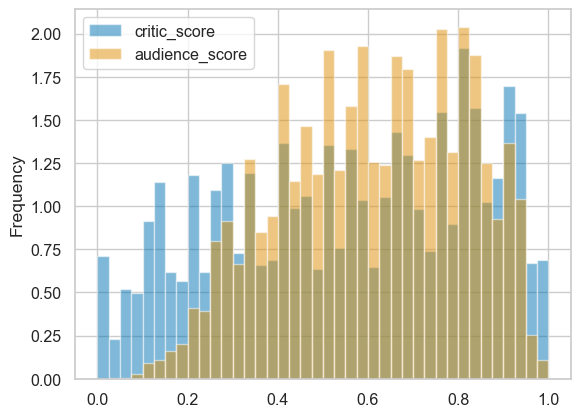

In [28]:
imdb_tomatoes[['critic_score', 'audience_score']].plot(kind='hist', bins=40, alpha=0.5, density=True)

In [29]:
critic_sorted = imdb_tomatoes.sort_values('critic_score', ascending=False)
critic_sorted[(critic_sorted['audience_score'] < 0.5) & ((critic_sorted['votes'].isna()) | (critic_sorted['votes'] > 100000))].head(20)

,title,release_date,critic_score,audience_score,release_year,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
3263,Spy Kids,"Released Mar 30, 2001",0.93,0.47,2001,tt0227538,Spy Kids,2001,PG,88 min,"Action, Adventure, Comedy",5.6,"Using high tech gadgets, two kids have to save...",Robert Rodriguez,/name/nm0001675/,"Alexa PenaVega, \nDaryl Sabara, \nAntonio Band...","/name/nm0891786/,/name/nm0754512/,/name/nm0000...",120052.0,112719001.0
5713,Ad Astra,"Released Sep 20, 2019",0.83,0.40,2019,tt2935510,Ad Astra,2019,PG-13,123 min,"Adventure, Drama, Mystery",6.5,Astronaut Roy McBride undertakes a mission acr...,James Gray,/name/nm0336695/,"Brad Pitt, \nTommy Lee Jones, \nRuth Negga, \n...","/name/nm0000093/,/name/nm0000169/,/name/nm1550...",240629.0,50188370.0
5932,I Care a Lot,2020,0.79,0.36,2020,tt9893250,I Care a Lot,2020,R,118 min,"Comedy, Crime, Drama",6.3,A crooked legal guardian who drains the saving...,J Blakeson,/name/nm2128335/,"Rosamund Pike, \nPeter Dinklage, \nEiza Gonzál...","/name/nm0683253/,/name/nm0227759/,/name/nm2555...",135261.0,NaN
5630,Captain Marvel,"Released Mar 8, 2019",0.79,0.45,2019,tt4154664,Captain Marvel,2019,PG-13,123 min,"Action, Adventure, Sci-Fi",6.8,Carol Danvers becomes one of the universe's mo...,"Anna Boden, \nRyan Fleck",/name/nm1349818/,"Brie Larson, \nSamuel L. Jackson, \nBen Mendel...","/name/nm0281396/,/name/nm0488953/,/name/nm0000...",567887.0,426829839.0
1238,Mad Max Beyond Thunderdome,"Released Jul 1, 1985",0.79,0.49,1985,tt0089530,Mad Max Beyond Thunderdome,1985,PG-13,107 min,"Action, Adventure, Sci-Fi",6.2,After being exiled from the most advanced town...,"George Miller, \nGeorge Ogilvie",/name/nm0004306/,"Mel Gibson, \nTina Turner, \nBruce Spence, \nA...","/name/nm0644695/,/name/nm0000154/,/name/nm0877...",139409.5,36200000.0
5647,Captain Marvel,"Released Mar 8, 2019",0.79,0.45,2019,tt4154664,Captain Marvel,2019,PG-13,123 min,"Action, Adventure, Sci-Fi",6.8,Carol Danvers becomes one of the universe's mo...,"Anna Boden, \nRyan Fleck",/name/nm1349818/,"Brie Larson, \nSamuel L. Jackson, \nBen Mendel...","/name/nm0281396/,/name/nm0488953/,/name/nm0000...",567887.0,426829839.0
3809,War of the Worlds,"Released Jun 29, 2005",0.76,0.42,2005,tt0407304,War of the Worlds,2005,PG-13,116 min,"Action, Adventure, Sci-Fi",6.5,An alien invasion threatens the future of huma...,Steven Spielberg,/name/nm0000229/,"Tom Cruise, \nDakota Fanning, \nTim Robbins, \...","/name/nm0000129/,/name/nm0266824/,/name/nm0000...",454608.0,234280354.0
3867,War of the Worlds,"Released Jun 29, 2005",0.76,0.42,2005,tt0407304,War of the Worlds,2005,PG-13,116 min,"Action, Adventure, Sci-Fi",6.5,An alien invasion threatens the future of huma...,Steven Spielberg,/name/nm0000229/,"Tom Cruise, \nDakota Fanning, \nTim Robbins, \...","/name/nm0000129/,/name/nm0266824/,/name/nm0000...",454608.0,234280354.0
5072,Noah,"Released Mar 28, 2014",0.75,0.41,2014,tt1959490,Noah,2014,PG-13,138 min,"Action, Adventure, Drama",5.8,Noah is chosen by God to undertake a momentous...,Darren Aronofsky,/name/nm0004716/,"Russell Crowe, \nJennifer Connelly, \nAnthony ...","/name/nm0000128/,/name/nm0000124/,/name/nm0000...",257697.0,101200044.0
4919,Killing Them Softly,"Released Nov 30, 2012",0.74,0.44,2012,tt1764234,Killing Them Softly,2012,R,97 min,"Crime, Drama, Thriller",6.2,Jackie Cogan is an enforcer hired to restore o...,Andrew Dominik,/name/nm0231596/,"Brad Pitt, \nRay Liotta, \nRichard Jenkins, \n...","/name/nm0000093/,/name/nm0000501/,/name/nm0420...",147076.0,15026056.0


In [30]:
audience_sorted = imdb_tomatoes.sort_values('audience_score', ascending=False)
audience_sorted[(audience_sorted['critic_score'] < 0.5) & ((audience_sorted['votes'].isna()) | (audience_sorted['votes'] > 100000))].head(20)

,title,release_date,critic_score,audience_score,release_year,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
6340,The Hill,"Released Aug 25, 2023",0.44,0.97,2023,tt8051894,The Hill,2023,NaN,NaN,"Biography, Drama, Sport",NaN,The remarkable true-life story of Ricky Hill's...,Jeff Celentano,/name/nm0147985/,"Dennis Quaid, \nScott Glenn, \nBonnie Bedelia,...","/name/nm0000598/,/name/nm0001277/,/name/nm0000...",NaN,NaN
6341,The Hill,"Released Aug 25, 2023",0.44,0.97,2023,tt8051894,The Hill,2023,NaN,NaN,"Biography, Drama, Sport",NaN,The remarkable true-life story of Ricky Hill's...,Jeff Celentano,/name/nm0147985/,"Dennis Quaid, \nScott Glenn, \nJoelle Carter, ...","/name/nm0000598/,/name/nm0001277/,/name/nm0141...",NaN,NaN
6305,Sweetwater,"Released Apr 14, 2023",0.25,0.95,2023,tt2365971,Sweetwater,2023,NaN,NaN,"Drama, Sport",NaN,"In the fall of 1950, Nat ""Sweetwater"" Clifton ...",Martin Guigui,/name/nm0346841/,"Cary Elwes, \nEric Roberts, \nRichard Dreyfuss...","/name/nm0000144/,/name/nm0000616/,/name/nm0000...",NaN,NaN
5728,Maleficent: Mistress of Evil,"Released Oct 18, 2019",0.39,0.95,2019,tt4777008,Maleficent: Mistress of Evil,2019,PG,119 min,"Adventure, Family, Fantasy",6.6,Maleficent and her goddaughter Aurora begin to...,Joachim Rønning,/name/nm1461392/,"Angelina Jolie, \nElle Fanning, \nHarris Dicki...","/name/nm0001401/,/name/nm1102577/,/name/nm6170...",108233.0,113929605.0
5705,Angel Has Fallen,"Released Aug 23, 2019",0.38,0.93,2019,tt6189022,Angel Has Fallen,2019,R,121 min,"Action, Thriller",6.4,Mike Banning is framed for the attempted assas...,Ric Roman Waugh,/name/nm0006846/,"Gerard Butler, \nFrederick Schmidt, \nDanny Hu...","/name/nm0124930/,/name/nm5520750/,/name/nm0396...",100728.0,69030436.0
6055,Red Notice,"Released Nov 5, 2021",0.36,0.92,2021,tt7991608,Red Notice,2021,PG-13,118 min,"Action, Comedy, Thriller",6.3,An Interpol agent successfully tracks down the...,Rawson Marshall Thurber,/name/nm1098493/,"Dwayne Johnson, \nRyan Reynolds, \nGal Gadot, ...","/name/nm0425005/,/name/nm0005351/,/name/nm2933...",282505.0,NaN
3096,The Boondock Saints,"Released Aug 4, 1999",0.26,0.91,1999,tt0144117,The Boondock Saints,1999,R,108 min,"Action, Thriller",7.7,Two Irish Catholic brothers become vigilantes ...,Troy Duffy,/name/nm0240627/,"Willem Dafoe, \nSean Patrick Flanery, \nNorman...","/name/nm0000353/,/name/nm0001218/,/name/nm0005...",241527.0,25812.0
3701,Man on Fire,"Released Apr 21, 2004",0.39,0.89,2004,tt0328107,Man on Fire,2004,R,146 min,"Action, Crime, Drama",7.7,"In Mexico City, a former CIA operative swears ...",Tony Scott,/name/nm0001716/,"Denzel Washington, \nChristopher Walken, \nDak...","/name/nm0000243/,/name/nm0000686/,/name/nm0266...",367938.0,77911774.0
6218,Black Adam,"Released Oct 21, 2022",0.39,0.88,2022,tt6443346,Black Adam,2022,PG-13,125 min,"Action, Adventure, Fantasy",6.4,"Nearly 5,000 years after he was bestowed with ...",Jaume Collet-Serra,/name/nm1429471/,"Dwayne Johnson, \nAldis Hodge, \nPierce Brosna...","/name/nm0425005/,/name/nm0388038/,/name/nm0000...",222941.0,NaN
6289,Shazam! Fury of the Gods,"Released Mar 17, 2023",0.49,0.86,2023,tt10151854,Shazam! Fury of the Gods,2023,PG-13,130 min,"Action, Adventure, Comedy",NaN,The film continues the story of teenage Billy ...,David F. Sandberg,/name/nm2497546/,"Helen Mirren, \nZachary Levi, \nMeagan Good, \...","/name/nm0000545/,/name/nm1157048/,/name/nm0328...",NaN,NaN


In [31]:
critic_sorted_oscar = imdb_tomatoes_oscar.sort_values('critic_score', ascending=False)
critic_sorted_oscar[(critic_sorted_oscar['audience_score'] < 0.5)].groupby('movie_id').first().sort_values('critic_score', ascending=False)

,title,release_date,critic_score,audience_score,release_year,movie_name,year,certificate,runtime,genre,...,Class,CanonicalCategory,Category,NomId,Film,FilmId,Name,Nominees,NomineeIds,Winner
movie_id,,,,,,,,,,,,,,,,,,,,,
tt0037465,Wilson,"Released Aug 1, 1944",0.89,0.41,1944,Wilson,1944,Passed,154 min,"Biography, Drama, History",...,Directing,DIRECTING,DIRECTING,an0052568,Wilson,tt0037465,Henry King,Henry King,nm0454771,False
tt0095593,Married to the Mob,"Released Aug 19, 1988",0.88,0.49,1988,Married to the Mob,1988,R,104 min,"Comedy, Crime, Romance",...,Acting,ACTOR IN A SUPPORTING ROLE,ACTOR IN A SUPPORTING ROLE,an0054315,Married to the Mob,tt0095593,Dean Stockwell,Dean Stockwell,nm0001777,False
tt0088213,Swing Shift,"Released Mar 13, 1984",0.87,0.42,1984,Swing Shift,1984,PG,100 min,"Drama, Romance, War",...,Acting,ACTRESS IN A SUPPORTING ROLE,ACTRESS IN A SUPPORTING ROLE,an0052832,Swing Shift,tt0088213,Christine Lahti,Christine Lahti,nm0001441,False
tt2935510,Ad Astra,"Released Sep 20, 2019",0.83,0.40,2019,Ad Astra,2019,PG-13,123 min,"Adventure, Drama, Mystery",...,Production,SOUND MIXING,SOUND MIXING,an1296003,Ad Astra,tt2935510,"Gary Rydstrom, Tom Johnson and Mark Ulano","Gary Rydstrom, Tom Johnson, Mark Ulano","nm0003977,nm0426348,nm0880360",False
tt0086992,The Bostonians,"Released Aug 2, 1984",0.81,0.37,1984,The Bostonians,1984,Not Rated,122 min,"Drama, Romance",...,Acting,ACTRESS IN A LEADING ROLE,ACTRESS IN A LEADING ROLE,an0052822,The Bostonians,tt0086992,Vanessa Redgrave,Vanessa Redgrave,nm0000603,False
tt0079123,The Europeans,"Released Oct 8, 1979",0.80,0.38,1979,The Europeans,1979,None,90 min,"Drama, Romance",...,Production,COSTUME DESIGN,COSTUME DESIGN,an0057121,The Europeans,tt0079123,Judy Moorcroft,Judy Moorcroft,nm0600844,False
tt0407304,War of the Worlds,"Released Jun 29, 2005",0.76,0.42,2005,War of the Worlds,2005,PG-13,116 min,"Action, Adventure, Sci-Fi",...,Production,SOUND MIXING,SOUND MIXING,an0057384,War of the Worlds,tt0407304,"Andy Nelson, Anna Behlmer and Ronald Judkins","Andy Nelson, Anna Behlmer, Ronald Judkins","nm0625144,nm0066933,nm0431954",False
tt0096943,Blaze,"Released Dec 13, 1989",0.75,0.49,1989,Blaze,1989,R,120 min,"Biography, Comedy, Drama",...,Production,CINEMATOGRAPHY,CINEMATOGRAPHY,an0052748,Blaze,tt0096943,Haskell Wexler,Haskell Wexler,nm0005549,False
tt0071385,Daisy Miller,"Released May 22, 1974",0.69,0.32,1974,Daisy Miller,1974,G,91 min,"Comedy, Drama, Romance",...,Production,COSTUME DESIGN,COSTUME DESIGN,an0053379,Daisy Miller,tt0071385,John Furness,John Furness,nm0299054,False


In [32]:
audience_sorted_oscar = imdb_tomatoes_oscar.sort_values('audience_score', ascending=False)
audience_sorted_oscar[(audience_sorted_oscar['critic_score'] < 0.5)].groupby('movie_id').first().sort_values('audience_score', ascending=False).head(20)

,title,release_date,critic_score,audience_score,release_year,movie_name,year,certificate,runtime,genre,...,Class,CanonicalCategory,Category,NomId,Film,FilmId,Name,Nominees,NomineeIds,Winner
movie_id,,,,,,,,,,,,,,,,,,,,,
tt4777008,Maleficent: Mistress of Evil,"Released Oct 18, 2019",0.39,0.95,2019,Maleficent: Mistress of Evil,2019,PG,119 min,"Adventure, Family, Fantasy",...,Production,MAKEUP AND HAIRSTYLING,MAKEUP AND HAIRSTYLING,an1295923,Maleficent: Mistress of Evil,tt4777008,"Paul Gooch, Arjen Tuiten and David White","Paul Gooch, Arjen Tuiten, David White","nm0328655,nm1115465,nm0924675",False
tt0068883,Ludwig,"Released Mar 8, 1973",0.33,0.89,1973,Ludwig,1973,R,238 min,"Biography, Drama, History",...,Production,COSTUME DESIGN,COSTUME DESIGN,an0050479,Ludwig,tt0068883,Piero Tosi,Piero Tosi,nm0869200,False
tt0078199,"Same Time, Next Year","Released Nov 22, 1978",0.40,0.85,1978,"Same Time, Next Year",1978,PG,119 min,"Comedy, Drama, Romance",...,Production,CINEMATOGRAPHY,CINEMATOGRAPHY,an0050162,"Same Time, Next Year",tt0078199,Robert Surtees,Robert Surtees,nm0005892,False
tt0107840,Poetic Justice,"Released Jul 23, 1993",0.34,0.83,1993,Poetic Justice,1993,R,109 min,"Drama, Romance",...,Music,MUSIC (Original Song),MUSIC (Original Song),an0049110,Poetic Justice,tt0107840,"Music and Lyric by Janet Jackson, James Harris...","Janet Jackson, James Harris III, Terry Lewis","nm0001390,nm0005047,nm0507805",False
tt0397535,Memoirs of a Geisha,"Released Dec 23, 2005",0.36,0.83,2005,Memoirs of a Geisha,2005,PG-13,145 min,"Drama, Romance",...,Production,ART DIRECTION,ART DIRECTION,an0057359,Memoirs of a Geisha,tt0397535,Art Direction: John Myhre; Set Decoration: Gre...,"John Myhre, Gretchen Rau","nm0616924,nm0711956",True
tt0097481,Harlem Nights,"Released Nov 17, 1989",0.26,0.80,1989,Harlem Nights,1989,R,116 min,"Comedy, Crime, Drama",...,Production,COSTUME DESIGN,COSTUME DESIGN,an0052759,Harlem Nights,tt0097481,Joe I. Tompkins,Joe I. Tompkins,nm0867001,False
tt0102057,Hook,"Released Dec 11, 1991",0.29,0.76,1991,Hook,1991,PG,142 min,"Adventure, Comedy, Family",...,Production,MAKEUP AND HAIRSTYLING,MAKEUP,an0049503,Hook,tt0102057,"Christina Smith, Monty Westmore, Greg Cannom","Christina Smith, Monty Westmore, Greg Cannom","nm0807702,nm0922881,nm0134148",False
tt0101902,For the Boys,"Released Nov 22, 1991",0.44,0.75,1991,For the Boys,1991,R,138 min,"Comedy, Drama, Music",...,Acting,ACTRESS IN A LEADING ROLE,ACTRESS IN A LEADING ROLE,an0049444,For the Boys,tt0101902,Bette Midler,Bette Midler,nm0000541,False
tt0073335,Mahogany,"Released Oct 8, 1975",0.29,0.75,1975,Mahogany,1975,PG,109 min,"Drama, Romance",...,Music,MUSIC (Original Song),MUSIC (Original Song),an0051355,Mahogany,tt0073335,Music by Michael Masser; Lyrics by Gerry Goffin,"Michael Masser, Gerry Goffin","nm0557247,nm1132342",False


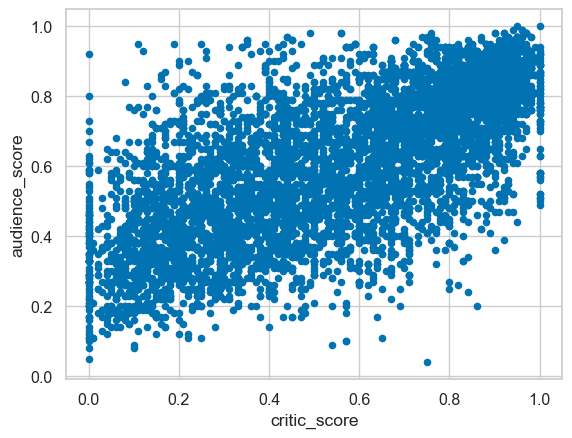

In [33]:
imdb_tomatoes.plot(kind='scatter', x='critic_score', y='audience_score');

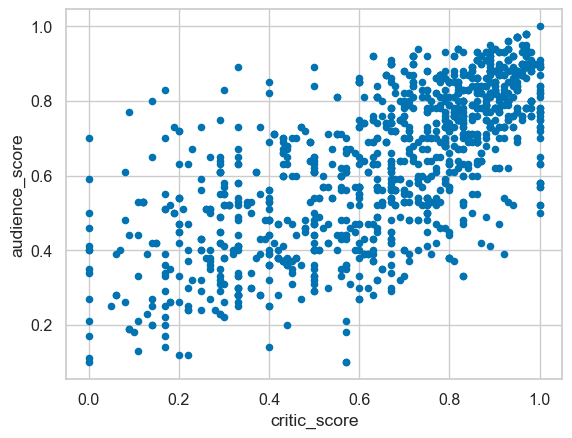

In [34]:
imdb_tomatoes[(imdb_tomatoes['year']<1985)].plot(kind='scatter', x='critic_score', y='audience_score');